In [4]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

In [5]:
import re
re_tag = re.compile(r'<[^>]+>')
def rm_tags(text):
    return re_tag.sub('',text)

In [8]:
import os
def read_files(filetype):
    path="data/aclImdb/"
    file_list=[]
    
    positive_path=path+filetype+'/pos/'
    for f in os.listdir(positive_path):
        file_list +=[positive_path+f]
    
    negative_path=path+filetype+'/neg/'
    for f in os.listdir(negative_path):
        file_list+=[negative_path+f]
    
    print('read',filetype,'files:',len(file_list))
    
    all_labels =([1]*12500 +[0]*12500)
    all_texts=[]
    for fi in file_list:
        with open(fi,encoding='utf8') as file_input:
            all_texts +=[rm_tags(" ".join(file_input.readlines()))]
    return all_labels,all_texts

In [9]:
y_train,train_text=read_files("train")

read train files: 25000


In [10]:
y_test,test_text=read_files("test")

read test files: 25000


In [11]:
#按照每一个英文单词在影评中出现的次数进行排序，排序的前3800名单词会列入字典中
token =Tokenizer(num_words=3800)
token.fit_on_texts(train_text)

In [13]:
#将文字转换为数字列表
x_train_seq = token.texts_to_sequences(train_text)
x_test_seq =token.texts_to_sequences(test_text)

#截取
x_train =sequence.pad_sequences(x_train_seq,maxlen=380)
x_test =sequence.pad_sequences(x_test_seq,maxlen=380)

建立模型

In [14]:
from keras.models import Sequential
from keras.layers.core import Dense,Dropout,Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN

model=Sequential()
model.add(Embedding(output_dim=32,input_dim=3800,input_length=380))
model.add(Dropout(0.35))

model.add(SimpleRNN(units=16))

model.add(Dense(units=256,activation='relu'))
model.add(Dropout(0.35))

model.add(Dense(units=1,activation='sigmoid'))

model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 380, 32)           121600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 380, 32)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 16)                784       
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4352      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 126,993
Trainable params: 126,993
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])

In [17]:
train_history=model.fit(x_train,y_train,batch_size=100,
                       epochs=10,verbose=2,
                       validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
 - 13s - loss: 0.5823 - acc: 0.6851 - val_loss: 0.5718 - val_acc: 0.7438
Epoch 2/10
 - 13s - loss: 0.3566 - acc: 0.8508 - val_loss: 0.5047 - val_acc: 0.7930
Epoch 3/10
 - 12s - loss: 0.2836 - acc: 0.8896 - val_loss: 1.0087 - val_acc: 0.6104
Epoch 4/10
 - 12s - loss: 0.2385 - acc: 0.9071 - val_loss: 0.5081 - val_acc: 0.8096
Epoch 5/10
 - 12s - loss: 0.1905 - acc: 0.9286 - val_loss: 0.5755 - val_acc: 0.8122
Epoch 6/10
 - 12s - loss: 0.1512 - acc: 0.9452 - val_loss: 0.8244 - val_acc: 0.7652
Epoch 7/10
 - 12s - loss: 0.1406 - acc: 0.9475 - val_loss: 0.8100 - val_acc: 0.7596
Epoch 8/10
 - 12s - loss: 0.1208 - acc: 0.9564 - val_loss: 0.7060 - val_acc: 0.7996
Epoch 9/10
 - 12s - loss: 0.1010 - acc: 0.9630 - val_loss: 0.6296 - val_acc: 0.8058
Epoch 10/10
 - 12s - loss: 0.0948 - acc: 0.9659 - val_loss: 0.8624 - val_acc: 0.8004


In [18]:
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.xlabel('Epoch')
    plt.ylabel(train)
    plt.legend(['train','validation'],loc='upper left')
    plt.show()

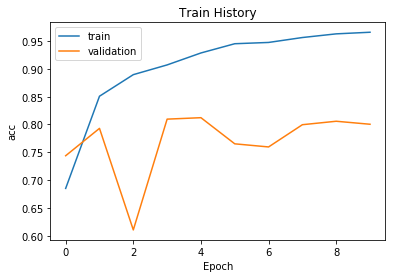

In [19]:
show_train_history(train_history,'acc','val_acc')

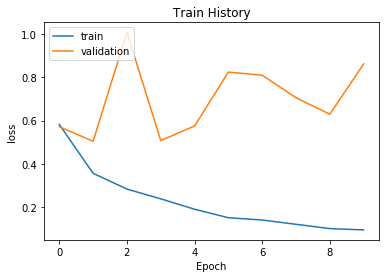

In [21]:
show_train_history(train_history,'loss','val_loss')

In [22]:
scores=model.evaluate(x_test,y_test,verbose=1)
scores[1]

25000/25000 [==============================] - 8s 322us/step


0.847

预测概率

In [23]:
probility=model.predict(x_test)
probility[:10]

array([[0.99911124],
       [0.9987789 ],
       [0.9174209 ],
       [0.9989249 ],
       [0.97808915],
       [0.998089  ],
       [0.99936265],
       [0.9986517 ],
       [0.9962608 ],
       [0.99832433]], dtype=float32)

In [24]:
for p in probility[12500:12510]:
    print(p)

[0.01512494]
[7.65747e-05]
[0.00091698]
[0.0018846]
[0.00084886]
[0.00129309]
[0.9955291]
[0.00018947]
[0.00124169]
[0.02859059]


预测结果

In [25]:
predict =model.predict_classes(x_test)
predict[:10]

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [26]:
predict.shape

(25000, 1)

In [27]:
predict_classes=predict.reshape(25000)
predict_classes

array([1, 1, 1, ..., 0, 1, 1])

查看预测结果

In [29]:
SentimentDict ={1:'正面的',0:'负面的'}
def display_test_Sentiment(i):
    print(test_text[i])
    print('label真实值：',SentimentDict[y_test[i]],
         '预测结果：',SentimentDict[predict_classes[i]])

In [30]:
display_test_Sentiment(2)

As a recreational golfer with some knowledge of the sport's history, I was pleased with Disney's sensitivity to the issues of class in golf in the early twentieth century. The movie depicted well the psychological battles that Harry Vardon fought within himself, from his childhood trauma of being evicted to his own inability to break that glass ceiling that prevents him from being accepted as an equal in English golf society. Likewise, the young Ouimet goes through his own class struggles, being a mere caddie in the eyes of the upper crust Americans who scoff at his attempts to rise above his standing. What I loved best, however, is how this theme of class is manifested in the characters of Ouimet's parents. His father is a working-class drone who sees the value of hard work but is intimidated by the upper class; his mother, however, recognizes her son's talent and desire and encourages him to pursue his dream of competing against those who think he is inferior.Finally, the golf scenes

In [32]:
model_json =model.to_json()
with open("saveModel/Imdb_RNN_model.json",'w') as json_file:
    json_file.write(model_json)

model.save_weights("saveModel/Imdb_RNN_model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
model=load_model('saveModel/Imdb_RNN_model.h5')